In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from ultralytics import YOLO
from PIL import Image

2023-12-31 09:50:20.635582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 09:50:21.759689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1 Try the models on the whole image
Try the predictions on some subset of the dates. There is definitely space for further work but this project gives very solid baseline.

/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:394: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


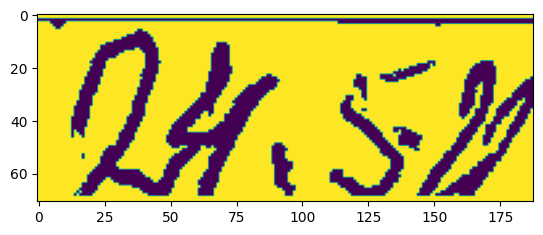

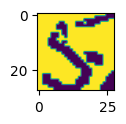

5 1.0


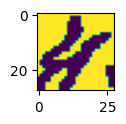

4 1.0


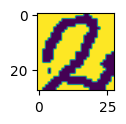

2 1.0


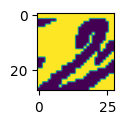

8 0.9180499


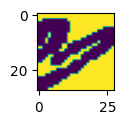

4 0.99854517


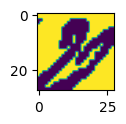

8 0.9999888


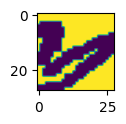

8 0.9918447


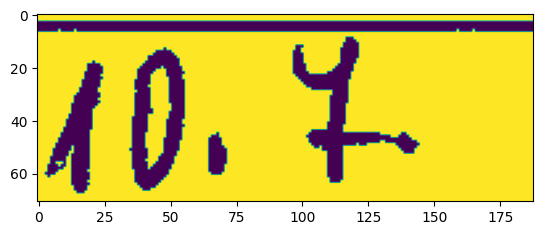

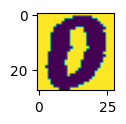

0 1.0


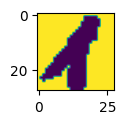

1 1.0


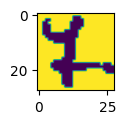

7 0.99680746


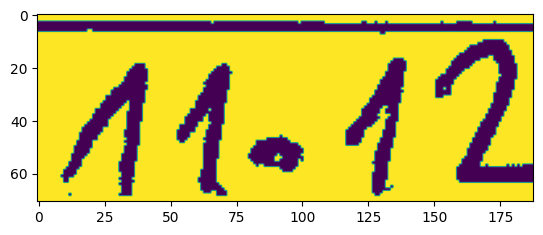

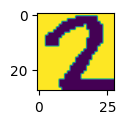

2 1.0


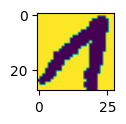

1 1.0


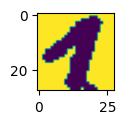

1 0.9999999


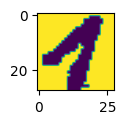

1 1.0


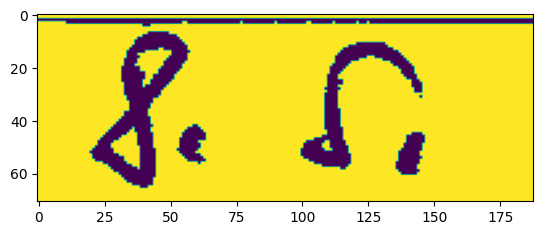

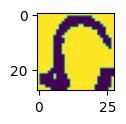

5 0.99664164


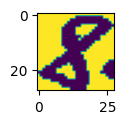

8 1.0


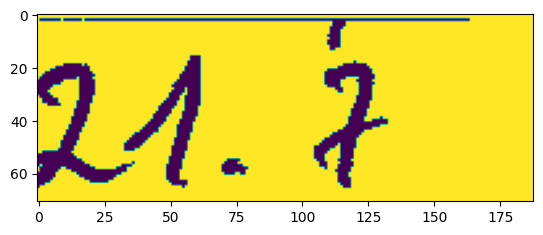

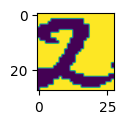

2 1.0


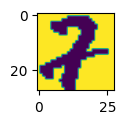

7 1.0


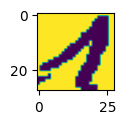

1 1.0


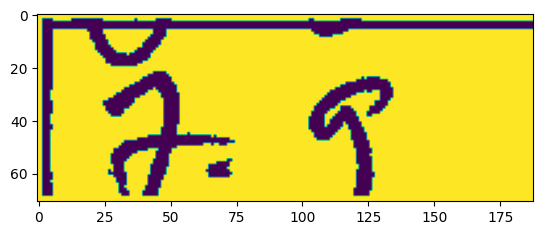

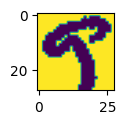

9 0.7704323


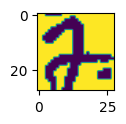

7 0.9974106


In [2]:
def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

IMG_WIDTH = 188
IMG_HEIGHT = 71
IMG_WIDTH_ORIGINAL = IMG_WIDTH + 15
IMG_HEIGHT_ORIGINAL = IMG_HEIGHT
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

yolo_model = YOLO('yolo6/runs/detect/train/weights/best.pt')
classification_model = tf.keras.models.load_model('models/custom-data-cnn.keras')

def load_image(path):
    img = Image.open(path)

    img = convert_from_image_to_cv2(img)

    # Convert to gray scale, erode and crop the edges
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 215, 255, cv2.THRESH_BINARY)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    eroded_image = cv2.erode(thresholded, rect_kernel, iterations = 1)
    eroded_image[0:2, :] = 255
    eroded_image[:, 0:2] = 255
    eroded_image[:, -2:] = 255
    eroded_image[-2:, :] = 255
    
    cropped_image = eroded_image[0:IMG_HEIGHT_ORIGINAL, 15:IMG_WIDTH_ORIGINAL]
    return Image.fromarray(cropped_image)

for img_id in range(1019, 1025):
    img = load_image(f'data-dates/{img_id}.png')
    plt.imshow(img)
    plt.show()
    
    results = yolo_model(img, verbose=False)
    for idx, box in enumerate(results[0].boxes.xyxy.numpy()):
        if results[0].boxes.cls[idx] in [0, 2]:
            continue
        if results[0].boxes.xywh.numpy()[idx][3] <= 40:
            continue
        
        character = img.crop(box)
        character = np.array(character)
       
        character = cv2.resize(character, dsize=(28, 28), interpolation=cv2.INTER_LINEAR)
        
        _, character = cv2.threshold(character, 250, 255, cv2.THRESH_BINARY)
        plt.figure(figsize=(1,1))
        plt.imshow(character)
        plt.show()
        character = np.array(character).reshape(-1, 28, 28, 1)
        character = character.astype(np.float32)
        character = 255. - character
        
        res = classification_model(character)
        print(np.argmax(res), np.max(res))